# 数据增强

在考虑做数据增强的时候，如果数据量和数据多样性无法保证，则根据检测结果来确定大致的错误原因，尽量去模拟多场景；

##### 1）根据当前效果，有如下几个问题：

In [1]:
# a. 光照原因；所以要考虑色彩、对比度等.
# b. 安装角度和位置不同，所以成像大小和角度不同，所以要做旋转.
# c. 考虑到聚焦，要做模糊.（如果不考虑聚焦可以选择不做）
# d. 考虑镜头脏、考虑加cover. 所以要考虑加noise.
# e. 逆光的增强尝试；

##### 2) 所以我们要做如下动作：

In [2]:
# a. 先将demo旋转；
# b. 然后将上述几种增强随机选择；
# c. 使用Mosaic将数据集增强；

##### 3）建议增加数量为1/3~1/2; 大致900~1400张左右；

##### 4） 环境要求：

In [3]:
# a. 编程语言：python；
# b. package要求：python==3.10.4; opencv-python==4.7.0; pillow==9.2.0； matplotlib==3.7.2; numpy==1.24.3;

##### 5）根据在线资料，我们测试了如下demo,具体参考各个增强动作：（使用方法，参考本文件最后）

/tmp/ipykernel_12726/4241549855.py:19: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img_orig = img_orig.resize((320, 320),Image.ANTIALIAS) # 压缩图片至320*320


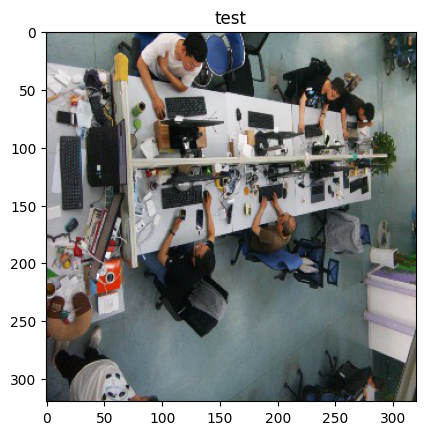

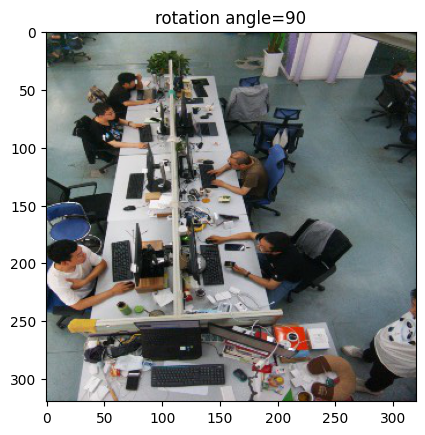

In [4]:
from PIL import Image
import matplotlib.pyplot as plt
import cv2 as cv
import numpy as np
import random
from random import choice


# 显示img
def display(img, title="test"):
    if isinstance(img, np.ndarray):
        img = Image.fromarray(cv.cvtColor(img,cv.COLOR_BGR2RGB))
        
    plt.title(title)
    plt.imshow(img)
    plt.show()

img_orig = Image.open(r"/home/zhangyouan/桌面/zya/IMX500/IMX500/work/wafer_support/images_orig/20230607071007095.jpg")
img_orig = img_orig.resize((320, 320),Image.ANTIALIAS) # 压缩图片至320*320
display(img_orig)

# 1. 原图逆时针旋转
img_orig_rot = img_orig.rotate(90)
title='rotation angle='+ str(90)
display(img_orig_rot, title)
img_orig_rot_cv = cv.cvtColor(np.asarray(img_orig_rot),cv.COLOR_RGB2BGR)

In [5]:
# 2. 模糊画质；--> 对焦问题；
def blur_img(img): 
    kernel_list = [3, 5]
    kernel = int(random.choice(kernel_list))
    blur_img = cv.blur(img, (kernel,kernel))
    gaussian_blur_img = cv.GaussianBlur(img, (kernel, kernel), 0)
    median_blur_img = cv.medianBlur(img, kernel)
    bi_blur = cv.bilateralFilter(img, kernel, sigmaColor=75, sigmaSpace=75)
    noise_list = [blur_img, gaussian_blur_img, median_blur_img, bi_blur]
    img_cv = random.choice(noise_list)
    
    title = 'random noise add, kernel='+ str(kernel)
    # display(img_cv, title)
    return blur_img

blur_img = blur_img(img_orig_rot_cv)


In [6]:
# 3. 随机旋转和缩放；--> 角度问题；
def Rotated_image(img):  
    angle = random.randint(-90, 90)  # 随机旋转角度；
    scale = random.uniform(0.8, 1.8)  # 随机缩放比例
    height, width = img.shape[:2]
    center = (width // 2, height // 2)
    matrix = cv.getRotationMatrix2D(center, angle, scale) #旋转中心，旋转角度，缩放比例
    rotated_image = cv.warpAffine(img, matrix, (width, height))
    
    title = "rotated_img, rotated angle: " + str(angle) + ",scale:" + str(scale)[0:4]
    # display(rotated_image, title)
    return rotated_image

rotated_image = Rotated_image(img_orig_rot_cv)

In [7]:
# 4. 随机明暗；--> 环境亮暗问题
def Adjusted_image(img):
    brightness_factor = random.uniform(0.5, 1.5)  # 随机明暗参数
    image_float = img.astype(np.float32)
    adjusted_image = image_float * brightness_factor
    # 将图像像素值限制在[0, 255]范围内
    adjusted_image = np.clip(adjusted_image, 0, 255)
    adjusted_image = adjusted_image.astype(np.uint8)
    
    title = "bright, bright paremeter: " + str(brightness_factor)[0:4]
    # display(adjusted_image, title)
    return adjusted_image

Adjust_image = Adjusted_image(img_orig_rot_cv)

In [8]:
# 5. 随机增加高斯分布；随机噪声： https://zhuanlan.zhihu.com/p/431327446
# demo 如下
def noisy(img):
    '''
    ### 添加噪声 ###
    img: 图像
    cj_type: {gauss: gaussian, sp: salt & pepper}
    '''
    noisy_list = ["gauss", "sp"]
    noise_type = choice(noisy_list)
    if noise_type == "gauss":
        image=img.copy() 
        mean=0
        st=0.4
        gauss = np.random.normal(mean,st,image.shape)
        gauss = gauss.astype('uint8')
        image = cv.add(image,gauss)
        
    elif noise_type == "sp":
        image=img.copy() 
        prob = 0.01 # 有噪声的概率, 可以调大调小；
        if len(image.shape) == 2:
            black = 0
            white = 255            
        else:
            colorspace = image.shape[2]
            if colorspace == 3:  # RGB
                black = np.array([0, 0, 0], dtype='uint8')
                white = np.array([255, 255, 255], dtype='uint8')
            else:  # RGBA
                black = np.array([0, 0, 0, 255], dtype='uint8')
                white = np.array([255, 255, 255, 255], dtype='uint8')
        probs = np.random.random(image.shape[:2])
        image[probs < (prob / 2)] = black
        image[probs > 1 - (prob / 2)] = white
    
    title = "noise_type=" + str(noise_type)
    # display(img, title)
    return image
    
cv_noisy_img = noisy(img_orig_rot_cv)


In [9]:
# 6. 考虑对比度，色度，亮度等； 参考：https://zhuanlan.zhihu.com/p/431327446
# 下面是demo;
def colorjitter(img):
    '''
    ### 不同的颜色抖动 ###
    img: 图像
    cj_type: {b: brightness, s: saturation, c: constast}
    '''
    jitter_list = ["b", "s","c"]
    cj_type = choice(jitter_list)
    if cj_type == "b":
        # value = random.randint(-50, 50)
        value = np.random.choice(np.array([-50, -40, -30, 30, 40, 50]))
        hsv = cv.cvtColor(img, cv.COLOR_BGR2HSV)
        h, s, v = cv.split(hsv)
        if value >= 0:
            lim = 255 - value
            v[v > lim] = 255
            v[v <= lim] += value
        else:
            lim = np.absolute(value)
            v[v < lim] = 0
            v[v >= lim] -= np.absolute(value)

        final_hsv = cv.merge((h, s, v))
        img = cv.cvtColor(final_hsv, cv.COLOR_HSV2BGR)
        
    elif cj_type == "s":
        # value = random.randint(-50, 50)
        value = np.random.choice(np.array([-50, -40, -30, 30, 40, 50]))
        hsv = cv.cvtColor(img, cv.COLOR_BGR2HSV)
        h, s, v = cv.split(hsv)
        if value >= 0:
            lim = 255 - value
            s[s > lim] = 255
            s[s <= lim] += value
        else:
            lim = np.absolute(value)
            s[s < lim] = 0
            s[s >= lim] -= np.absolute(value)

        final_hsv = cv.merge((h, s, v))
        img = cv.cvtColor(final_hsv, cv.COLOR_HSV2BGR)
    
    elif cj_type == "c":
        brightness = 10
        contrast = random.randint(40, 100)
        dummy = np.int16(img)
        dummy = dummy * (contrast/127+1) - contrast + brightness
        dummy = np.clip(dummy, 0, 255)
        img = np.uint8(dummy)

    title = "jitter_color:" + str(cj_type)
    # display(img, title)
    return img

cv_jitter_img = colorjitter(img_orig_rot_cv)

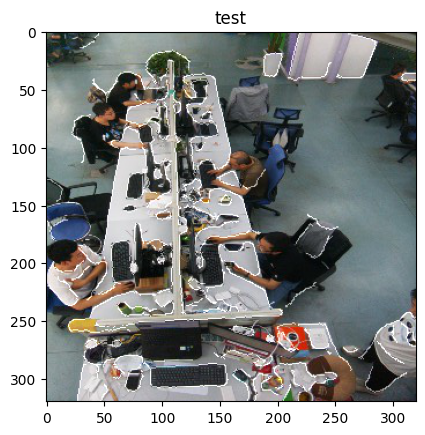

In [10]:
# 7. 假设逆光场景；
def simulate_backlight(image):
    # 调整图像的亮度和对比度
    alpha = 1.5  # 亮度增益
    beta = -100  # 对比度增益
    adjusted_image = cv.convertScaleAbs(image, alpha=alpha, beta=beta)

    # 将图像转换为灰度
    gray_image = cv.cvtColor(adjusted_image, cv.COLOR_BGR2GRAY)

    # 使用高斯滤波来平滑图像
    blurred_image = cv.GaussianBlur(gray_image, (15, 15), 0)

    # 检测边缘
    edges = cv.Canny(blurred_image, threshold1=30, threshold2=100)

    # 创建一个全黑的掩模
    mask = np.zeros_like(image)

    # 在掩模上绘制检测到的边缘
    mask[edges != 0] = [255, 255, 255]

    # 合并原始图像和掩模，模拟逆光效果
    result = cv.addWeighted(image, 1, mask, 0.5, 0)

    return result


sim_img = simulate_backlight(img_orig_rot_cv)
display(sim_img)


# Mosaic

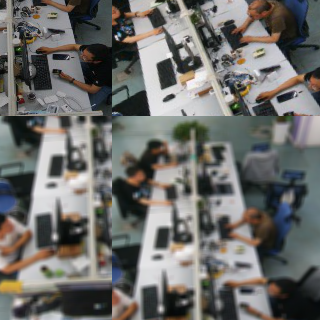

In [11]:
# 8. 随机裁剪算法
def random_mosaic(img_list, img_size = 320):# img_list[0] is PIL format
    img1, img2, img3, img4 = img_list[0], img_list[1], img_list[2], img_list[3]
    
    # 获取图像的宽度和高度
    height, width, channels = img1.shape
    
    # 定义mosaic图像的大小
    mosaic_width= width
    mosaic_height= height
    
    # 创建一个空白的mosaic图像
    mosaic = np.zeros((mosaic_height, mosaic_width, 3), dtype=np.uint8)
    
    # 随机初始化拼接图像的中心点坐标，在[320*0.2~320*0.8]之间随机取2个数作为拼接图像的中心坐标
    xc, yc = [int(random.randint(img_size*0.2, img_size*0.8)) for _ in range(2)]
    
    # 随机裁剪各个img的各个部分；
    # 填充第1个部分
    start_x = np.random.randint(0, img_size - xc)  
    start_y = np.random.randint(0, img_size - yc)  
    cropped_region1 = img1[start_x:start_x+xc, start_y:start_y+yc, :]
    mosaic[0:xc, 0:yc, :] = cropped_region1
    
    # 填充第2个部分
    start_x = np.random.randint(0, img_size - xc)  
    start_y = np.random.randint(0, yc)  
    cropped_region2 = img2[start_x:start_x+xc, start_y:start_y+img_size-yc, :]
    mosaic[0:xc, yc:img_size, :] = cropped_region2
    
    # 填充第3个部分
    start_x = np.random.randint(0, xc)  
    start_y = np.random.randint(0, img_size - yc)  
    cropped_region3 = img3[start_x:start_x+img_size-xc, start_y:start_y+yc, :]
    mosaic[xc:img_size, 0:yc, :] = cropped_region3
    
    # 填充第4个部分
    start_x = np.random.randint(0, xc)  
    start_y = np.random.randint(0, yc)  
    cropped_region4 = img4[start_x:start_x+img_size-xc, start_y:start_y+img_size-yc, :]
    mosaic[xc:img_size, yc:img_size, :] = cropped_region4 
    
    # showing
    img = cv.cvtColor(np.asarray(mosaic),cv.COLOR_RGB2BGR)
    mosaic = Image.fromarray(cv.cvtColor(mosaic,cv.COLOR_BGR2RGB))
    title = "Mosaic"
    # display(mosaic, title)
    return mosaic

img_list = [Adjust_image, rotated_image, blur_img, blur_img]    
random_mosaic(img_list, img_size = 320)

# Main函数
#### 从路径下随机取4张图片，然后对这4张图片随机增强。然后拼接成mosaic图片；

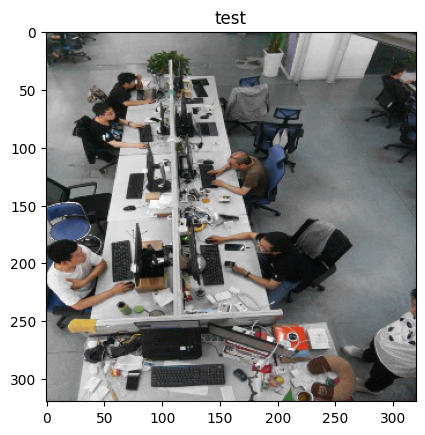

In [12]:
def switch_case(case, img_cv):
    Operate_Aug_dict = {
        'Noise': noisy(img_cv),
        'dark': Adjusted_image(img_cv),
        'rotation': Rotated_image(img_cv),
        'simulate_backlight': simulate_backlight(img_cv),
        'colorjitter': colorjitter(img_cv), 
        # 'blur_img': blur_img(img_cv), 
    }
    return Operate_Aug_dict.get(case)

result = switch_case("colorjitter", img_orig_rot_cv)
display(result)

# 主要的使用方法：

In [13]:
# 1. 先准备环境；如本页最上面的版本要求；
# 2. img_fold_path 为原始图片的文件夹；
# 3. img_save_path 为增强完的图片的保存的位置的文件夹；
# 4. for i in range(10)， range(10) 里面的10是一共希望生成多少张图片；
# 5. Aug_f = ['Noise', 'dark', 'rotation', 'colorjitter'] 分别是，加噪声，变明暗，旋转角度，和增强对比度等；

In [14]:
import os
from random import sample
import time

# img_fold_path = "/home/zhangyouan/桌面/zya/IMX500/IMX500/work/wafer_support/pre-pro/"
img_fold_path = "/home/zhangyouan/桌面/zya/IMX500/IMX500/work/wafer_support/images_orig/"
img_save_path = "/home/zhangyouan/桌面/zya/IMX500/IMX500/work/wafer_support/aug/"
img_list = os.listdir(img_fold_path)
img_path_list = [img_fold_path+i for i in img_list]

count = 0

for i in range(10):  # 设置总共随机取多少次；就会生成多少张图片
    img_chosen_list = sample(img_path_list, 4)  # 随机取4个；
    # 随机使用一些预处理方法，然后进行叠加；
    img_list = [Image.open(h) for h in img_chosen_list]
    
    for j, j_value in enumerate(img_list):
        img_list[j] = j_value.resize((320, 320),Image.ANTIALIAS) # 压缩图片至320*320
        img_list[j] = cv.cvtColor(np.asarray(img_list[j].rotate(90)),cv.COLOR_RGB2BGR)
    
    # 随机选取4种处理方法
    # Aug_f = ['Noise', 'dark', 'rotation', 'simulate_backlight', 'colorjitter']
    Aug_f = ['Noise', 'dark', 'rotation', 'colorjitter']
    Aug_ch = sample(Aug_f, 4)
    for j, j_value in enumerate(range(4)):
        img_list[j] = switch_case(Aug_ch[j], img_list[j])
    
    result = random_mosaic(img_list)
    
    # 将结果保存
    # display(result)
    # print(type(result))
    result.save( img_save_path + str(int(float(time.time())*1000))+".jpg")
    

    

/tmp/ipykernel_12726/4066431693.py:19: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img_list[j] = j_value.resize((320, 320),Image.ANTIALIAS) # 压缩图片至320*320
